# Prescription Parser

We are gonna extract some meaningful information from medical prescription which is available in pdf files.
- Step 1: Convert pdf to image using **pdf2image** library
- Step 2: Preprocess the image (Apply **adaptive thresholding using OpenCV2**)
- Step 3: Extracting text from image by passing it through **tesseract OCR engine**
- Step 4: Finding useful information from text using **RegEx**

In [1]:
# importing necessary libraries
from pdf2image import convert_from_path
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
from PIL.PpmImagePlugin import PpmImageFile # used as type hint
from typing import Dict # used as type hint

# Setting required paths related to library functions
POPPLER_PATH = r"C:\poppler-24.02.0\Library\bin"
TESSERACT_ENGINE_PATH = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = TESSERACT_ENGINE_PATH

In [2]:
# Path of prescription_doc file
DOC_PATH = r"E:\Projects\medical-data-extraction\backend\resources\prescription\pre_1.pdf"

In [3]:
# Converting pdf to images (function returns a PIL Image object)
pages = convert_from_path(DOC_PATH, poppler_path=POPPLER_PATH)
pages

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>]

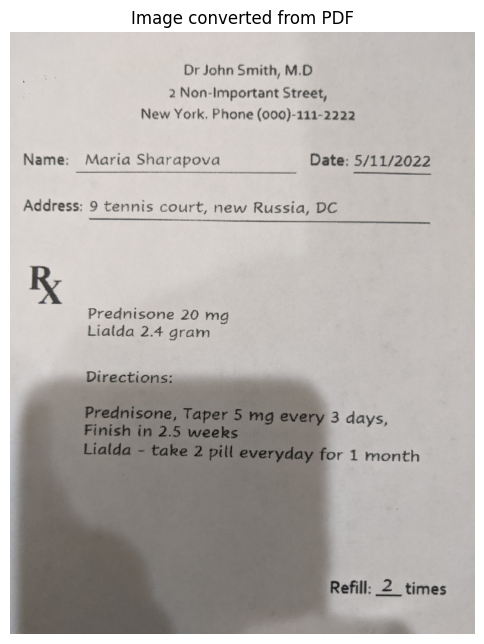

In [4]:
# Lets visualize our image
# pages[0].show() -> this PIL show() function opens image in a new window
plt.figure(figsize=(6,8))
plt.imshow(pages[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.show()

In [5]:
# Extract text from image using pytesseract
text = pytesseract.image_to_string(pages[0], lang="eng")
print(text)

Dr John Smith, M.D
2 Non-Important Street,
New York, Phone (000)-111-2222

Name: Maria Sharapova Date: 5/11/2022

Address: 9 tennis court, new Russia, DC

—moemenmannenneneneunmnnnnennieesisiyoinnitniahadaaanniihsnseneneneeeernnttnnneenrenen:

Prednisone 20 mg
Lialda 2.4 gram

3 days,

or 1 month



🔎 **Observation:** Pytesseract couldn't extract text under the shadow in our image. Also a long unknown string after address.

💡 **Solution:** Apply image thresholding using OpenCV2 (ref: [cv2 documentation](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html))

Types of thresholding:
1) Simple Thresholding:
> For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value. The function `cv.threshold` is used to apply the thresholding.

2) Adaptive Thresholding:
> In simple thresholding, we use one global value as a threshold. But this might not be good in all cases, e.g. if an image has different lighting conditions in different areas. In that case, adaptive thresholding can help. Here, the algorithm determines the threshold for a pixel based on a small region around it. So we get different thresholds for different regions of the same image which gives better results for images with varying illumination.

**We will use adaptive thresholding**

In [6]:
# A function to preprocess our image
def preprocess_image(img: PpmImageFile) -> np.ndarray:
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY) # Color image -> Grayscale image
    resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR) # Up-sizing for better extraction results
    processed_image = cv2.adaptiveThreshold(
        resized, # our resized image
        255, # max pixel value
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # adaptive thresholding
        # cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, # converting to binary (only black/white)
        63, # block size (after trial and error)
        12  # constant (after trial and error)
    )
    return processed_image

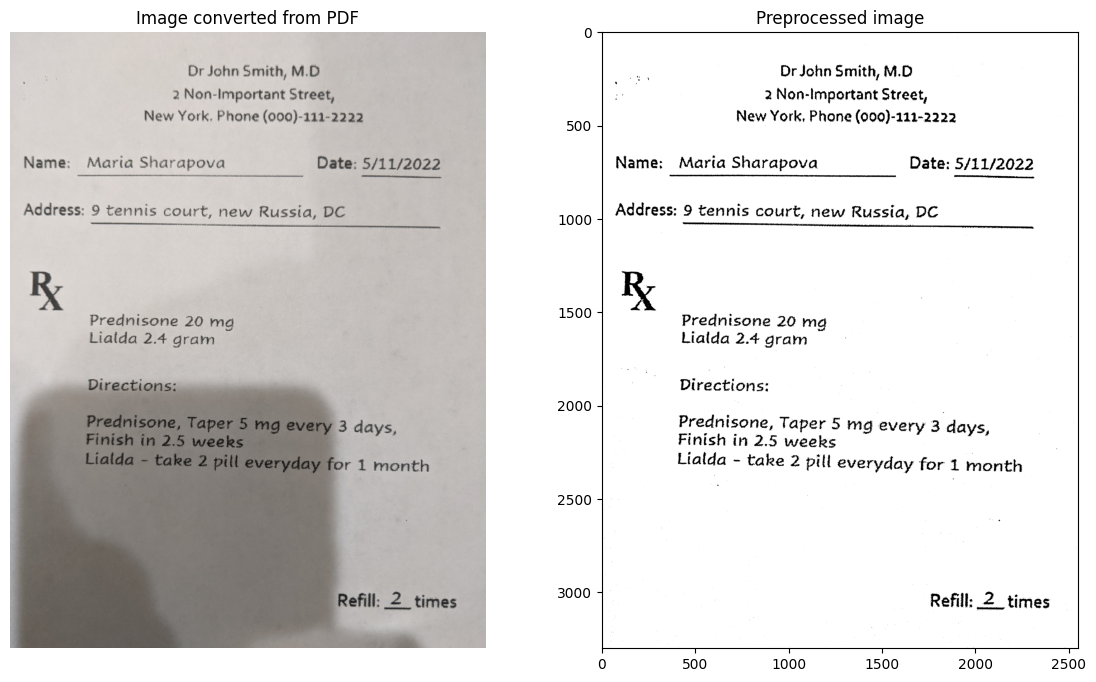

In [7]:
# Applying preprocessing on image
img = preprocess_image(pages[0])

# Visualize our images before and after preprocessing
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.imshow(pages[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis()
plt.title("Preprocessed image")
plt.show()

In [8]:
# Extract text from preprocessed image
text_1 = pytesseract.image_to_string(img, lang="eng")
print(text_1)

Dr John Smith, M.D
2 Non-Important Street,
New York, Phone (000)-111-2222

Name: Marta Sharapova Date: 5/11/2022

Address: 9 tennis court, new Russia, DC

Prednisone 20 md
Lialda 2.4 gram

Directions:

Prednisone, Taper 5 mg every 3 days,
Finish in 2.5 weeks 7
Lialda - take 2 pill everyday for 1 month

Refill: _2_times



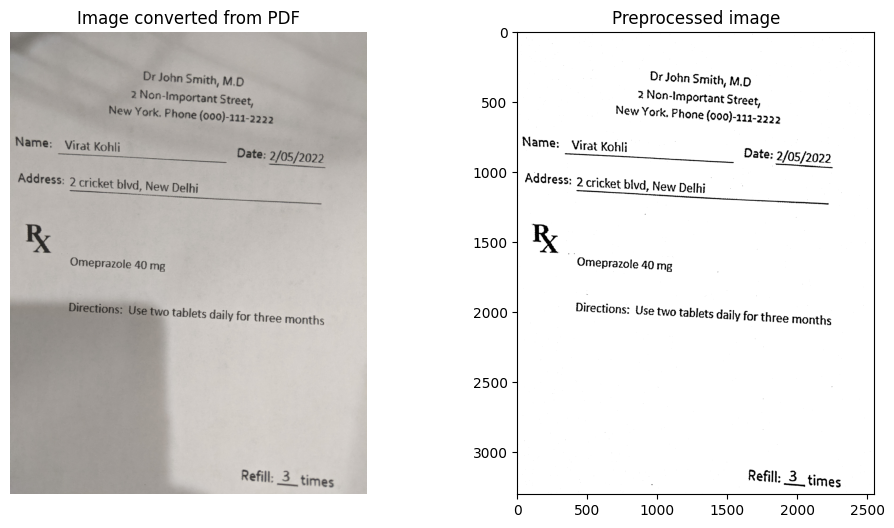

-----------------------------Text--------------------------------------
Dr John Smith, M.D

2 Non-Important street,
New York, Phone (900)-12123- ~2222

Name:  Virat Kohli Date: 2/05/2022

Address: 2 cricket blvd, New Delhi

| Omeprazole 40 mg

Directions: Use two tablets daily for three months

Refill: 3 times



In [9]:
# Let's try extracting text from our second prescription
DOC_PATH_1 = r"E:\Projects\medical-data-extraction\backend\resources\prescription\pre_2.pdf"
pages_1 = convert_from_path(DOC_PATH_1, poppler_path=POPPLER_PATH)
img = preprocess_image(pages_1[0])
# Visualize our images before and after preprocessing
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(pages_1[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis()
plt.title("Preprocessed image")
plt.show()
print("-----------------------------Text--------------------------------------")
text_2 = pytesseract.image_to_string(img, lang="eng")
print(text_2)

In [10]:
# A function to return useful information in JSON format
def parse(text: str) -> Dict:
    return{
        "patient_name": get_field("patient_name", text),
        "patient_address": get_field("patient_address", text),
        "medicines": get_field("medicines", text),
        "directions": get_field("directions", text),
        "refill": get_field("refill", text)
    }        

# A function to find useful information from our text using Regular Expressions
def get_field(field_name: str, text: str) -> str:
    pattern_dict = {
        "patient_name": {"pattern": "Name:(.*)Date", "flags": 0},
        "patient_address": {"pattern": "Address:(.*)\n", "flags": 0},
        "medicines": {"pattern": "Address:[^\n]*(.*)Directions", "flags": re.DOTALL},
        "directions": {"pattern": "Directions:.(.*)Refill", "flags": re.DOTALL},
        "refill": {"pattern": "Refill:.*(\d).*times", "flags": 0},
    }

    pattern_object = pattern_dict.get(field_name)
    if pattern_object:
        matches = re.findall(pattern_object["pattern"], text, flags=pattern_object["flags"])
        if len(matches) > 0:
            return matches[0].strip()

In [11]:
# Let's get useful fields from our texts
text_list = [text_1, text_2]
for i in range(len(text_list)):
    print(f"Important fields from text {i+1}:\n")
    print(parse(text_list[i]))
    print("\n----------------------\n")

Important fields from text 1:

{'patient_name': 'Marta Sharapova', 'patient_address': '9 tennis court, new Russia, DC', 'medicines': 'Prednisone 20 md\nLialda 2.4 gram', 'directions': 'Prednisone, Taper 5 mg every 3 days,\nFinish in 2.5 weeks 7\nLialda - take 2 pill everyday for 1 month', 'refill': '2'}

----------------------

Important fields from text 2:

{'patient_name': 'Virat Kohli', 'patient_address': '2 cricket blvd, New Delhi', 'medicines': '| Omeprazole 40 mg', 'directions': 'Use two tablets daily for three months', 'refill': '3'}

----------------------

